In [105]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import keras.backend as K
import math
from tensorflow.keras import initializers
import tensorflow_addons as tfa
import random
import matplotlib.pyplot as plt
import os
from tqdm.autonotebook import tqdm
from IPython import display

In [106]:
class AnomalyAttention(keras.layers.Layer):
	def __init__(self, num_heads, seqs, d_model):
		super(AnomalyAttention, self).__init__()
		
		self.depth = d_model // num_heads
		self.seqs = seqs
		self.num_heads = num_heads
		self.d_model = d_model

		self.wq = keras.layers.Dense(d_model, input_shape=(None,self.seqs,self.d_model), use_bias=False, name='wq')
		self.wk = keras.layers.Dense(d_model, input_shape=(None,self.seqs,self.d_model), use_bias=False, name='wk')
		self.wv = keras.layers.Dense(d_model, input_shape=(None,self.seqs,self.d_model), use_bias=False, name='wv')
		self.ws = keras.layers.Dense(num_heads, input_shape=(None,self.seqs,self.d_model), use_bias=False, name='ws')
		self.MLP_out = keras.layers.Dense(d_model, input_shape=(None,self.seqs,self.d_model), use_bias=False, name='MLP_out')

	def call(self,x):
		self.initialize(x)
		self.P = self.prior_association() # P = (batch_size, num_head, seqs, seqs)
		self.S = self.series_association() # S = (batch_size, num_head, seqs, seqs)
		z = self.attention()
		Z = self.MLP_out(z)

		return Z

	def initialize(self,x):
		# x = (batch_size, seqs, channels)
		self.Q = self.wq(x) # Q = (batch_size, seqs, d_model)
		self.K = self.wk(x) # K = (batch_size, seqs, d_model)
		self.V = self.wv(x) # V = (batch_size, seqs, d_model)
		self.sigma = self.ws(x) # sigma = (batch_size, seqs, num_head)
		# self.sigma = tf.abs(self.sigma)
		self.sigma = self.sigma + 1e-6
		self.split_Q = self.split_head(self.Q) # split_Q,K,V = (batch_size, num_head, seqs, depth)
		self.split_K = self.split_head(self.K)
		self.split_V = self.split_head(self.V)
		self.split_sigma = self.sigma_split(self.sigma) # split_sigma = (batch_size, num_head, seqs, 1)

	def prior_association(self):
		p = np.abs(np.indices((self.seqs,self.seqs))[0] - np.indices((self.seqs,self.seqs))[1]) # p = (seqs, seqs)
		p = p**2
		p = tf.constant(p, dtype='float32')
		p = -p / (2*(self.split_sigma**2)) # p = (batch_size, num_heads, seqs, seqs)
		gaussian = tf.math.exp(p)/(math.sqrt(2*math.pi)*self.split_sigma) # gaussian = (batch_size, num_heads, seqs, seqs)
		sum = tf.reduce_sum(gaussian, axis=-1, keepdims=True)
		return gaussian/sum

	def split_head(self,x):
		# Q = (batch_size, seqs, out_channels) / sigma = (batch_size, seqs, num_head)
		split = tf.transpose(x, perm=[0,2,1]) # Q = (batch_size, out_channels, seqs) / sigma = (batch_size, num_head, seqs)
		split = tf.reshape(split, [-1, self.num_heads, self.depth, self.seqs]) # Q = (batch_size, num_heads, depth, seqs) / sigma = (batch_size, num_heads, num_head/num_head, seqs)
		split = tf.transpose(split, perm=[0,1,3,2])

		return split
	
	def sigma_split(self,x):
		split = tf.transpose(x, perm=[0,2,1])
		split = tf.reshape(split, [-1, self.num_heads, 1, self.seqs])
		split = tf.transpose(split, perm=[0,1,3,2])
		
		return split

	def sm(self, x, axis):
		sub_max = x - tf.reduce_max(x, axis=axis, keepdims=True)
		exp = tf.math.exp(sub_max)
		sum = tf.reduce_sum(exp, keepdims=True, axis=axis)
		return exp/sum

	def series_association(self):
		split_value = self.sm(tf.matmul(self.split_Q, self.split_K, transpose_b=True)*math.sqrt(self.num_heads/self.d_model), axis=-1) # split_value = (batch_size, num_head, seqs, seqs)
		return split_value

	def attention(self):
		split_attention = tf.matmul(self.S,self.split_V) # split_attention = (batch_size, num_heads, seqs, depth)
		attention = tf.reshape(tf.transpose(split_attention, perm=[0,2,1,3]), [-1, self.seqs, self.d_model]) # attention = (batch_size, seqs, d_model)

		return attention

In [107]:
class AnomalyTransformerBlock(keras.layers.Layer):
	def __init__(self, seqs, d_model, f_dim, num_heads):
		super(AnomalyTransformerBlock, self).__init__()

		self.seqs = seqs
		self.f_dim = f_dim

		self.attention = AnomalyAttention(num_heads, seqs, d_model)
		self.ln1 = keras.layers.LayerNormalization(epsilon=1e-6)
		# self.ff = keras.Sequential([keras.layers.Dense(2048, kernel_initializer='glorot_uniform', activation='relu'), keras.layers.Dense(512, kernel_initializer='glorot_uniform')])
		self.ln2 = keras.layers.LayerNormalization(epsilon=1e-6)
		self.D1 = keras.layers.Dense(f_dim, kernel_initializer='glorot_uniform')
		# self.activation = tfa.activations.mish()
		self.D2 = keras.layers.Dense(d_model, kernel_initializer='glorot_uniform')

	def call(self,x):
		x_identity = x
		x = self.attention(x)
		x = tf.keras.layers.Dropout(rate=0.3)(x)
		z = self.ln1(x + x_identity)

		z_identity = z
		z = self.D1(z)
		z = tfa.activations.mish(z)
		z = self.D2(z)
		z = tf.keras.layers.Dropout(rate=0.3)(z)
		z = self.ln2(z + z_identity)

		return z

In [132]:
class AnomalyTransformer(tf.keras.Model):
	def __init__(self, seqs, in_channels, d_model, f_dim, num_heads):
		super(AnomalyTransformer, self).__init__()
		self.block1 = AnomalyTransformerBlock(seqs, d_model, f_dim, num_heads)
		self.block2 = AnomalyTransformerBlock(seqs, d_model, f_dim, num_heads)
		self.block3 = AnomalyTransformerBlock(seqs, d_model, f_dim, num_heads)
		self.in_channels = in_channels
		self.d_model = d_model
		self.seqs = seqs

	def call(self,x):
		x = tf.keras.layers.Dense(self.d_model, input_shape=(None, self.seqs, self.in_channels))(x)
		x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
		x = PositionalEncoding(self.seqs, self.d_model)(x)
		x = tf.keras.layers.Dropout(rate=0.3)(x)

		x1 = self.block1(x)
		self.prior_association1 = self.block1.attention.P
		self.series_association1 = self.block1.attention.S

		x2 = self.block2(x1)
		self.prior_association2 = self.block2.attention.P
		self.series_association2 = self.block2.attention.S

		x3 = self.block3(x2)
		self.prior_association3 = self.block3.attention.P
		self.series_association3 = self.block3.attention.S

		self.add_loss(self.AssDis(self.prior_association1,self.prior_association2,self.prior_association3,self.series_association1,self.series_association2,self.series_association3))

		x4 = tf.keras.layers.Dense(self.in_channels)(x3)

		return x4

	# def KL(self,p,s):
	# 	kl = p*tf.math.log((p+1e-4)/(s+1e-4))
	# 	KL = tf.reduce_sum(kl, axis=-1)
	# 	return KL
	
	def AssDis(self,P1,P2,P3,S1,S2,S3):
		# P1 = (batch_size, num_heads, seqs, seqs)
		kl = tf.keras.losses.KLDivergence(reduction=tf.keras.losses.Reduction.NONE)
		P1 = tf.reduce_mean(P1, axis=1) # P1 = (batch_size, seqs, seqs)
		P2 = tf.reduce_mean(P2, axis=1)
		P3 = tf.reduce_mean(P3, axis=1)

		S1 = tf.reduce_mean(S1, axis=1)
		S2 = tf.reduce_mean(S2, axis=1)
		S3 = tf.reduce_mean(S3, axis=1)

		R1 = kl(P1,S1) + kl(S1,P1) # R1 = (batch_size, seqs)
		R2 = kl(P2,S2) + kl(S2,P2)
		R3 = kl(P3,S3) + kl(S3,P3)

		R = (R1 + R2 + R3)/3 # R = (batch_size, seqs)
		
		return R
		

In [126]:
def loss_function(real, pred):
	D = real-pred
	D = D**2
	return tf.reduce_mean(D,axis=-1)

In [127]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001)

In [89]:
train = np.genfromtxt(os.path.join('ServerMachineDataset', 'train', 'machine-1-1.txt'), dtype=np.float32, delimiter=',')
test = np.genfromtxt(os.path.join('ServerMachineDataset', 'test', 'machine-1-1.txt'), dtype=np.float32, delimiter=',')
test_label = np.genfromtxt(os.path.join('ServerMachineDataset', 'test_label', 'machine-1-1.txt'), dtype=np.float32, delimiter=',')

In [90]:
# machine1
for i in range(2,9):
    train_ = np.genfromtxt(os.path.join('ServerMachineDataset', 'train', 'machine-1-' + str(i) + '.txt'), dtype=np.float32, delimiter=',')
    test_ = np.genfromtxt(os.path.join('ServerMachineDataset', 'test', 'machine-1-' + str(i) + '.txt'), dtype=np.float32, delimiter=',')
    test_label_ = np.genfromtxt(os.path.join('ServerMachineDataset', 'test_label', 'machine-1-' + str(i) + '.txt'), dtype=np.float32, delimiter=',')
    train = np.concatenate((train,train_))
    test = np.concatenate((test,test_))
    test_label = np.concatenate((test_label,test_label_))

In [91]:
# machine2
for i in range(1,10):
    train_ = np.genfromtxt(os.path.join('ServerMachineDataset', 'train', 'machine-2-' + str(i) + '.txt'), dtype=np.float32, delimiter=',')
    test_ = np.genfromtxt(os.path.join('ServerMachineDataset', 'test', 'machine-2-' + str(i) + '.txt'), dtype=np.float32, delimiter=',')
    test_label_ = np.genfromtxt(os.path.join('ServerMachineDataset', 'test_label', 'machine-2-' + str(i) + '.txt'), dtype=np.float32, delimiter=',')
    train = np.concatenate((train,train_))
    test = np.concatenate((test,test_))
    test_label = np.concatenate((test_label,test_label_))

In [92]:
# machine3
for i in range(1,12):
    train_ = np.genfromtxt(os.path.join('ServerMachineDataset', 'train', 'machine-3-' + str(i) + '.txt'), dtype=np.float32, delimiter=',')
    test_ = np.genfromtxt(os.path.join('ServerMachineDataset', 'test', 'machine-3-' + str(i) + '.txt'), dtype=np.float32, delimiter=',')
    test_label_ = np.genfromtxt(os.path.join('ServerMachineDataset', 'test_label', 'machine-3-' + str(i) + '.txt'), dtype=np.float32, delimiter=',')
    train = np.concatenate((train,train_))
    test = np.concatenate((test,test_))
    test_label = np.concatenate((test_label,test_label_))

In [93]:
train.shape

(708405, 38)

In [128]:
train_set = []
num = train.shape[0] // 100
for i in range(num):
    sample = train[i*100:(i+1)*100, :]
    train_set.append(sample)
train_set = np.array(train_set)

In [95]:
train_set.shape

(7084, 100, 38)

In [96]:
ratio = train_set.shape[0] // 5
mask = np.random.choice(train_set.shape[0], ratio, replace = False)
valid_set = train_set[mask]
print(valid_set.shape)
original_train_set = np.delete(train_set, mask, axis=0)
print(original_train_set.shape)

(1416, 100, 38)
(5668, 100, 38)


In [97]:
original_train_set.shape[0]//32

177

In [111]:
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)
    
    def get_angles(self, position, i , d_model):
        angles = 1 / tf.pow(10000, (2*(i//2))/ tf.cast(d_model, tf.float32))
        return position*angles

    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(
            position = tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i = tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model = d_model)

        sines = tf.math.sin(angle_rads[:, 0::2])

        cosines = tf.math.cos(angle_rads[:, 1::2])

        angle_rads = np.zeros(angle_rads.shape)
        angle_rads[:, 0::2] = sines
        angle_rads[:, 1::2] = cosines
        pos_encoding = tf.constant(angle_rads)
        pos_encoding = pos_encoding[tf.newaxis, ...]

        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

In [137]:
model = AnomalyTransformer(seqs=100, in_channels=38, d_model=512, f_dim=2024, num_heads=8)
epochs = 150
batch_size = 32
weights = 3
re_error_set = []
Assdis_set = []
for epoch in range(epochs):
	print("\nStart of epoch %d" % (epoch,))
	train_set = original_train_set
	# for k in range(train_set.shape[0]//batch_size):
	for k in tqdm(range(train_set.shape[0]//batch_size), total=train_set.shape[0]//batch_size):
		if k % 2 == 0 :
			batch_mask = np.random.choice(train_set.shape[0], batch_size, replace=False)
			batch = train_set[batch_mask]
			with tf.GradientTape() as tape:
				input = tf.constant(batch, dtype='float32')
				prediction = model(input)
				if tf.math.is_nan(tf.reduce_sum(prediction)) == True:
					assert 1 == 2
				reconstruction_error = tf.reduce_sum(tf.reduce_mean((prediction-input)**2, axis=-1), axis=-1)
				Assdis = model.losses[0]
				Assdis = tf.reduce_sum(tf.abs(Assdis), axis=-1)
				loss_value = reconstruction_error + Assdis*weights
				model.block1.attention.wq.trainable = False
				model.block2.attention.wq.trainable = False
				model.block3.attention.wq.trainable = False
				model.block1.attention.wk.trainable = False
				model.block2.attention.wk.trainable = False
				model.block3.attention.wk.trainable = False
				model.block1.attention.ws.trainable = True
				model.block2.attention.ws.trainable = True
				model.block3.attention.ws.trainable = True
			gradients = tape.gradient(loss_value, model.trainable_weights)
			optimizer.apply_gradients(zip(gradients, model.trainable_weights))
			if k % 10000 == 0:
				re_error_set.append(reconstruction_error)
				# Assdis_set.append(Assdis)
				print(
					"Reconstruction error (in minimize phase) at step %d: %.4f"
					% (k, float(tf.reduce_mean(reconstruction_error)))
				)
				print(
					"AssDis (in minimize phase) at step %d: %.4f"
					% (k, float(tf.reduce_mean(Assdis)))
				)
				print(
					"total loss (in minimize phase) at step %d: %.4f"
					% (k, float(tf.reduce_mean(loss_value)))
				)
			train_set = np.delete(train_set,batch_mask,axis=0)
		else:
			batch_mask = np.random.choice(train_set.shape[0], batch_size, replace=False)
			batch = train_set[batch_mask]		
			with tf.GradientTape() as tape:
				input = tf.constant(batch, dtype='float32')
				prediction = model(input)
				if tf.math.is_nan(tf.reduce_sum(prediction)) == True:
					assert 1 == 2
				reconstruction_error = tf.reduce_sum(tf.reduce_mean((prediction-input)**2, axis=-1), axis=-1)
				Assdis = model.losses[0]
				Assdis = tf.reduce_sum(tf.abs(Assdis), axis=-1)
				loss_value = reconstruction_error - Assdis*weights
				# loss_value = Assdis
				model.block1.attention.wq.trainable = True
				model.block2.attention.wq.trainable = True
				model.block3.attention.wq.trainable = True
				model.block1.attention.wk.trainable = True
				model.block2.attention.wk.trainable = True
				model.block3.attention.wk.trainable = True
				model.block1.attention.ws.trainable = False
				model.block2.attention.ws.trainable = False
				model.block3.attention.ws.trainable = False
			gradients = tape.gradient(loss_value, model.trainable_weights)
			optimizer.apply_gradients(zip(gradients, model.trainable_weights))
			if k % 10000 == 1:
				Assdis_set.append(Assdis)
				# re_error_set.append(reconstruction_error)
				print(
					"Reconstruction error (in maximize phase) at step %d: %.4f"
					% (k, float(tf.reduce_mean(reconstruction_error)))
				)
				print(
					"AssDis (in maximize phase) at step %d: %.4f"
					% (k, float(tf.reduce_mean(Assdis)))
				)
				print(
					"total loss (in maximize phase) at step %d: %.4f"
					% (k, tf.reduce_mean(loss_value))
				)
			train_set = np.delete(train_set,batch_mask,axis=0)
	display.clear_output()
model.save_weights('minmaxminmax')
import pickle
with open('reconsturct_list.pkl', 'wb') as f:
	pickle.dump(re_error_set,f)
with open('Assdis_list.pkl', 'wb') as f:
	pickle.dump(Assdis_set, f)


Start of epoch 72


  0%|          | 0/177 [00:00<?, ?it/s]

Reconstruction error (in minimize phase) at step 0: 6.7786
AssDis (in minimize phase) at step 0: 1269.9165
total loss (in minimize phase) at step 0: 3816.5278
Reconstruction error (in maximize phase) at step 1: 5.7506
AssDis (in maximize phase) at step 1: 1448.5167
total loss (in maximize phase) at step 1: -4339.7998


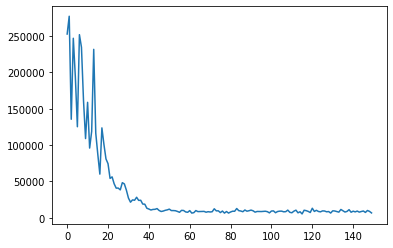

In [134]:
plt.plot(re_error_set)
plt.show()
# plt.savefig('reconstruction_error_1_4.png')

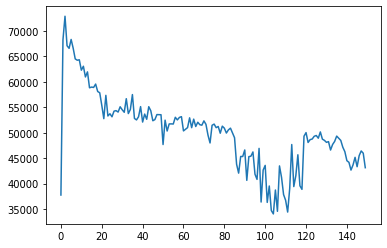

In [135]:
plt.plot(Assdis_set)
plt.show()
# plt.savefig('AssDis_1_4.png')

In [115]:
def softmax(x, axis):
	log = tf.math.exp(x - tf.reduce_max(x, keepdims=True, axis=axis))
	sum = tf.reduce_sum(log, keepdims=True, axis=axis)
	return log/sum

In [116]:
num = valid_set.shape[0]
valid_score_set = []
for i in range(num):
    input = np.array([valid_set[i]])
    pred = model(input)
    re_error = loss_function(input,pred)
    Assdis = model.losses[0]
    score = softmax(-Assdis,axis=-1)*re_error
    # score = re_error
    score = np.squeeze(score)
    valid_score_set.append(score)

In [117]:
score = np.array(valid_score_set)
score = np.reshape(score, (score.shape[0]*score.shape[1],))
sort_score = np.sort(score)
threshold = sort_score[round(score.shape[0]*0.995)]
threshold

0.121286064

In [118]:
test_set = []
test_num = test.shape[0] // 100
for i in range(test_num):
    sample = test[i*100:(i+1)*100, :]
    test_set.append(sample)

In [119]:
test_set = np.array(test_set)
test_set.shape

(7084, 100, 38)

In [120]:
label = test_label[:test_set.shape[0]*100]

In [121]:
test_score_set=[]
for i in range(test_num):
    input = np.array([test_set[i]])
    pred = model(input)
    re_error = loss_function(input,pred)
    Assdis = model.losses[0]
    normal_score = softmax(-Assdis,axis=-1)*re_error
    # normal_score = re_error
    normal_score = np.squeeze(normal_score)
    test_score_set.append(normal_score)

In [122]:
score_set = np.array(test_score_set)
score_set = np.reshape(score_set, (score_set.shape[0]*score_set.shape[1],))
score = np.zeros(shape=(score_set.shape[0],))
for i in range(len(score_set)):
    if score_set[i] > threshold:
        score[i] = 1
    else:
        score[i] = 0

In [123]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    print('Confusion Matrix')
    print(confusion)
    print('정확도:{}, 정밀도:{}, 재현율:{}'.format(accuracy, precision, recall))

In [124]:
get_clf_eval(label, score)

Confusion Matrix
[[675843   3113]
 [ 28909    535]]
정확도:0.9547967250141163, 정밀도:0.14665570175438597, 재현율:0.018170085586197527


In [125]:
from sklearn.metrics import f1_score

f1 = f1_score(label, score)
print('f1 score :', f1)

f1 score : 0.032334098875861236


In [60]:
import psutil
import os
print("=="*20)
print("== memory usage check")

# general RAM usage
memory_usage_dict = dict(psutil.virtual_memory()._asdict())
memory_usage_percent = memory_usage_dict['percent']
print(f"BEFORE CODE: memory_usage_percent: {memory_usage_percent}%")

# pid = os.getpid()
# current_process = psutil.Process(pid)
# current_process_memory_usage_as_KB = current_process.memory_info()[0] / 2.**20
# print(f"BEFORE CODE: Current memory KB   : {current_process_memory_usage_as_KB: 9.3f} KB")





# # AFTER  code
# memory_usage_dict = dict(psutil.virtual_memory()._asdict())
# memory_usage_percent = memory_usage_dict['percent']
# print(f"AFTER  CODE: memory_usage_percent: {memory_usage_percent}%")
# # current process RAM usage
# pid = os.getpid()
# current_process = psutil.Process(pid)
# current_process_memory_usage_as_KB = current_process.memory_info()[0] / 2.**20
# print(f"AFTER  CODE: Current memory KB   : {current_process_memory_usage_as_KB: 9.3f} KB")

== memory usage check
BEFORE CODE: memory_usage_percent: 11.3%


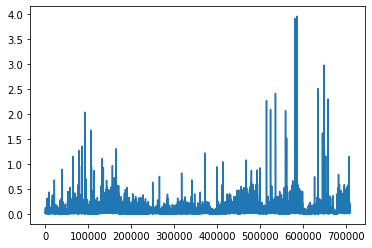

In [107]:
plt.plot(score_set)
plt.show()

In [108]:
import seaborn as sns

/home/minseok/miniforge3/envs/tf27/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

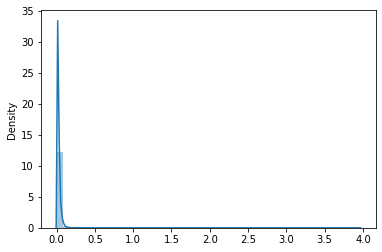

In [109]:
sns.distplot(score_set)